In [24]:
import os
import numpy as np
from PIL import Image, ImageFile
from skimage import io
import matplotlib.pyplot as plt
import psycopg2
import tifffile
from scipy import misc
from tifffile import TiffFile
from tifffile.tifffile import TIFF_DECOMPESSORS
from configparser import ConfigParser
from batch_tiff_to_jpeg import tiff_to_jpg
from psycopg2.extras import DictCursor
from visualization import get_connection, get_gta_image_jpg_dir
import progressbar
import random
from os import path
import math
import humanize
JPEG_DIR = 'D:/GTAV_extraction_output/rgb-jpeg'
JPEG_DIR_2 = 'Y:/GTA-jpg'
JPEG_DIRS = [JPEG_DIR, JPEG_DIR_2]
TIFF_DIR = 'D:/GTAV_extraction_output'

In [25]:
# threaded connection pooling
from psycopg2.pool import PersistentConnectionPool
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

conn_pool = None

def get_connection_pooled():
    """
    :rtype: connection
    """
    global conn_pool
    if conn_pool is None:
        CONFIG = ConfigParser()
        CONFIG.read("gta-postprocessing.ini")
        minimum = 1
        maximum = 28
        conn_pool = PersistentConnectionPool(minimum, maximum, CONFIG["Postgres"]["db"], cursor_factory=DictCursor)
    conn = conn_pool.getconn()
    conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
    return conn

#### selecting images metadata, grouping by position

In [26]:
conn = get_connection()
cur = conn.cursor()

# for each position, select first time and last time car was in this position
cur.execute("SELECT DISTINCT COUNT(camera_pos) AS count FROM snapshots")

position_count = cur.fetchone()['count']
# cur = conn.cursor('server_cursor_{}'.format(random.randint(0, 1e9)))
cur = conn.cursor()
print(cur.itersize)

cur.execute("""SELECT \
        ARRAY[st_x(camera_pos), st_y(camera_pos), st_z(camera_pos)] as position, \
    camera_pos, min(timestamp) AS minimum, max(timestamp) AS maximum, \
    min(imagepath), min(proj_matrix), \
    count(camera_pos) as count \
    FROM snapshots \
    GROUP BY camera_pos \
    ORDER BY min(timestamp) \
    """)

positions = {}
print('positions_total: {}'.format(position_count))

widgets = [progressbar.Percentage(), ' ', progressbar.Counter(), ' ', progressbar.Bar(), ' ', progressbar.FileTransferSpeed()]
pbar = progressbar.ProgressBar(widgets=widgets, max_value = cur.rowcount).start()

for i, row in enumerate(cur):
    pbar.update(i)
    positions[tuple(row['position'])] = {
        'min': row['minimum'],
        'max': row['maximum'],
        'time': row['maximum'] - row['minimum'],
        'position': row['position'],
        'count': row['count'],
        'index': i,
    }
pbar.finish()

print('total {} positions'.format(len(positions)))
# timespans = {key:pos['max'] - pos['min'] for key, pos in positions.items()}


2000


  7% 8394 |####                                                   |  45.0 KiB/s

positions_total: 133870


100% 110508 |#####################################################|  46.2 KiB/s


total 110508 positions


#### selecting images metadata, grouping by projection matrix

In [37]:
conn = get_connection()
cur = conn.cursor()

# for each position, select first time and last time car was in this position
cur.execute("SELECT DISTINCT COUNT(camera_pos) AS count FROM snapshots")

position_count = cur.fetchone()['count']
# cur = conn.cursor('server_cursor_{}'.format(random.randint(0, 1e9)))
cur = conn.cursor()
print(cur.itersize)

# somehow, grouping by proj matrix shows me same images, but grouping by camera pos does not
cur.execute("""SELECT \
        min(ARRAY[st_x(camera_pos), st_y(camera_pos), st_z(camera_pos)]) as position, \
    min(camera_pos), min(timestamp) AS minimum, max(timestamp) AS maximum, \
    min(imagepath), \
    proj_matrix, \
    count(proj_matrix) as count \
    FROM snapshots \
    GROUP BY proj_matrix \
    ORDER BY min(timestamp) \
    """)

projections = {}
print('positions_total: {}'.format(position_count))

widgets = [progressbar.Percentage(), ' ', progressbar.Counter(), ' ', progressbar.Bar(), ' ', progressbar.FileTransferSpeed()]
pbar = progressbar.ProgressBar(widgets=widgets, max_value = cur.rowcount).start()

for i, row in enumerate(cur):
    pbar.update(i)
#    print(tuple(tuple(x) for x in row['proj_matrix']))
    projections[tuple(tuple(x) for x in row['proj_matrix'])] = {
        'min': row['minimum'],
        'max': row['maximum'],
        'time': row['maximum'] - row['minimum'],
        'position': row['position'],
        'proj_matrix': row['proj_matrix'],
        'count': row['count'],
        'index': i,
    }
pbar.finish()

print('total {} projections'.format(len(projections)))
# timespans = {key:pos['max'] - pos['min'] for key, pos in positions.items()}


2000


  5% 5610 |##                                                     |  38.0 KiB/s

positions_total: 133870


100% 110782 |#####################################################|  35.3 KiB/s


total 110782 projections


#### display images per position

In [ ]:
offset = 38100
stride = 1
for position, data in sorted(positions.items(), key=lambda x:x[1]['index'])[offset::stride]:
    i = data['index']
    cur = conn.cursor()
    print(position)
# fucking python has only 1e-12 float position, which is not enough for postgres
    cur.execute("""SELECT \
        imagepath, \
        ARRAY[st_x(camera_pos), st_y(camera_pos)::double precision, st_z(camera_pos)::double precision] as position, \
        camera_pos \
    FROM snapshots \
      WHERE st_distance(camera_pos, ST_GeomFromText('POINT({} {} {})')) < 1e-9 \
    """.format(position[0], position[1], position[2]))

    print("i: {}, time: {}, same position images: {}".format(i, data['min'], cur.rowcount))
    for row in cur:
        img_path = path.join(JPEG_DIR, 'info-' + row['imagepath'] + '-0.jpg')
        if not path.exists(img_path):
            print('image not found')
            continue
        plt.figure(figsize=(15,15))
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()


#### display images per projection matrix

In [ ]:
offset = 39700
stride = 1
for projection, data in sorted(projections.items(), key=lambda x:x[1]['index'])[offset::stride]:
    i = data['index']
    cur = conn.cursor()
    print(projection)
# fucking python has only 1e-12 float position, which is not enough for postgres
    cur.execute("""SELECT \
        imagepath, \
        ARRAY[st_x(camera_pos), st_y(camera_pos)::double precision, st_z(camera_pos)::double precision] as position, \
        camera_pos \
    FROM snapshots \
      WHERE proj_matrix::NUMERIC[] = ARRAY{} \
    """.format(data['proj_matrix']))

    print("i: {}, time: {}, same proj_matrix images: {}".format(i, data['min'], cur.rowcount))
    for row in cur:
        img_path = path.join(JPEG_DIR, 'info-' + row['imagepath'] + '-0.jpg')
        if not path.exists(img_path):
            print('image not found')
            continue
        plt.figure(figsize=(15,15))
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()


In [ ]:
from decimal import *
print(float("431.63467407226560000"))
print(Decimal('431.63467407226560000'))
print(float("-55309.14581298830000000"))
              55309.1458129883
# float('431.63467')

In [ ]:
sorted(positions.items(), key=lambda x:x[1]['min'])

#### showing proj_image histogram

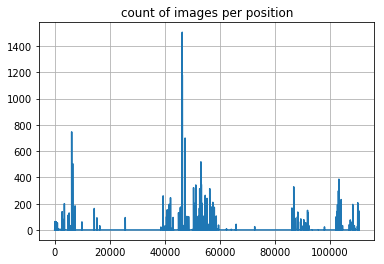

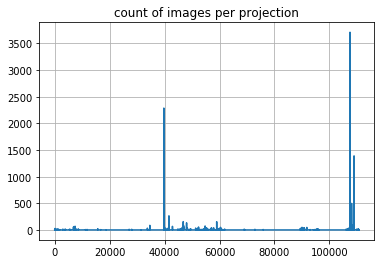

In [28]:
keys = [x['index'] for key, x in positions.items()]
values = [x['count'] for key, x in positions.items()]
plt.plot(keys, values)
plt.title('count of images per position')
plt.grid(True)
plt.show()

keys = [x['index'] for key, x in projections.items()]
values = [x['count'] for key, x in projections.items()]
plt.plot(keys, values)
plt.title('count of images per projection')
plt.grid(True)
plt.show()

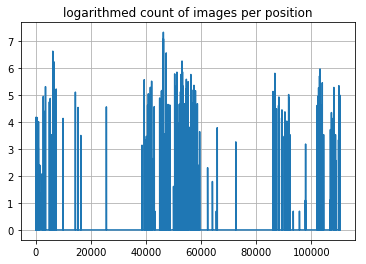

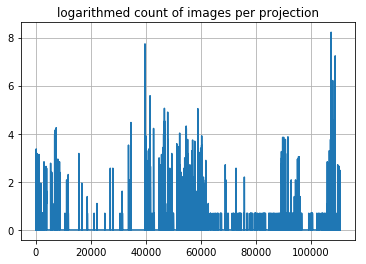

In [29]:
keys = [x['index'] for key, x in positions.items()]
values = [math.log(x['count']) for key, x in positions.items()]
plt.plot(keys, values)
plt.title('logarithmed count of images per position')
plt.grid(True)
plt.show()

keys = [x['index'] for key, x in projections.items()]
values = [math.log(x['count']) for key, x in projections.items()]
plt.plot(keys, values)
plt.title('logarithmed count of images per projection')
plt.grid(True)
plt.show()

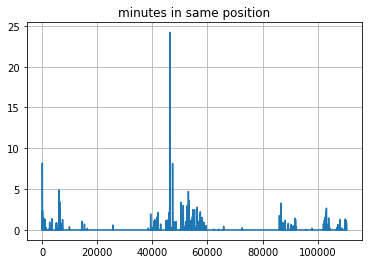

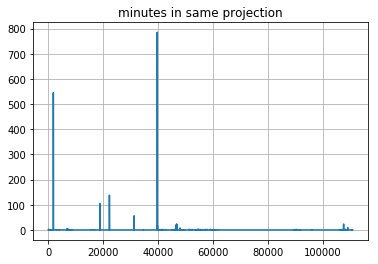

In [30]:
keys = [x['index'] for key, x in positions.items()]
values = [(x['max'] - x['min']).seconds / 60 for key, x in positions.items()]
plt.plot(keys, values)
plt.title('minutes in same position')
plt.grid(True)
plt.show()

keys = [x['index'] for key, x in projections.items()]
values = [(x['max'] - x['min']).seconds / 60 for key, x in projections.items()]
plt.plot(keys, values)
plt.title('minutes in same projection')
plt.grid(True)
plt.show()


#### filtering function

In [40]:
lag_interval_min = 20
treshold = 3000

def filter_lagged(data):
    return {key: x for key, x in data.items() if (((x['max'] - x['min']).seconds / 60) > lag_interval_min) if x['count'] >= treshold}

#### showing number of glitched by positions and projections

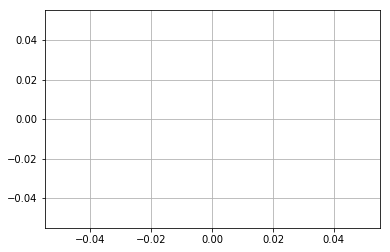

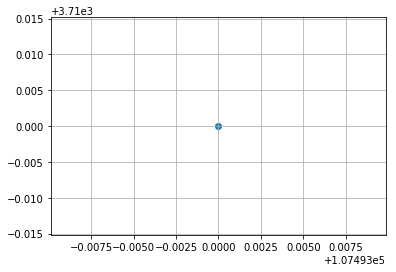

In [43]:
filtered = filter_lagged(positions)
keys = [x['index'] for key, x in filtered.items()]
values = [x['count'] for key, x in filtered.items()]
plt.scatter(keys, values)
plt.grid(True)
plt.show()

filtered = filter_lagged(projections)
keys = [x['index'] for key, x in filtered.items()]
values = [x['count'] for key, x in filtered.items()]
plt.scatter(keys, values)
plt.grid(True)
plt.show()


#### computing size of projected to be deleted

In [44]:
filtered = filter_lagged(projections)
total_size = 0

widgets = [progressbar.Percentage(), ' ', progressbar.Counter(), ' ', progressbar.Bar(), ' ', progressbar.FileTransferSpeed()]
pbar = progressbar.ProgressBar(widgets=widgets, max_value = len(filtered)).start()
j = 0
for projection, data in filtered.items():
    j += 1
    pbar.update(j)
    i = data['index']
    cur = conn.cursor()
    cur.execute("""SELECT \
        imagepath, \
        ARRAY[st_x(camera_pos), st_y(camera_pos)::double precision, st_z(camera_pos)::double precision] as position, \
        camera_pos \
    FROM snapshots \
      WHERE proj_matrix::NUMERIC[] = ARRAY{} \
    """.format(data['proj_matrix']))

#    print("i: {}, from: {}, to: {}, same proj_matrix images: {}".format(i, data['min'], data['max'], cur.rowcount))
    pbar1 = progressbar.ProgressBar(widgets=widgets, max_value = cur.rowcount).start()
    k = 0
    for row in cur:
        k += 1
        pbar1.update(k)
        img_path = path.join(JPEG_DIR, 'info-' + row['imagepath'] + '-0.jpg')
        if not path.exists(img_path):
            continue
        total_size += os.path.getsize(img_path)
        img_path = path.join(TIFF_DIR, 'info-' + row['imagepath'] + '.tiff')
        if not path.exists(img_path):
            continue
        total_size += os.path.getsize(img_path)
        img_path = path.join(TIFF_DIR, 'info-' + row['imagepath'] + '-depth.tiff')
        if not path.exists(img_path):
            continue
        total_size += os.path.getsize(img_path)
        img_path = path.join(TIFF_DIR, 'info-' + row['imagepath'] + '-stencil.tiff')
        if not path.exists(img_path):
            continue
        total_size += os.path.getsize(img_path)
    pbar1.finish()
pbar.finish()
        
print('total size is {}'.format(humanize.naturalsize(total_size)))

100% 3710 |#######################################################|   1.9 KiB/s
100% 1 |############################################################|   0.3 B/s


total size is 4.0 GB


In [45]:
total_size

4030834294

In [ ]:
filtered = filter_lagged(projections)
for projection, data in sorted(filtered.items(), key=lambda x:x[1]['index']):
    i = data['index']
    cur = conn.cursor()
    print(projection)
# fucking python has only 1e-12 float position, which is not enough for postgres
    cur.execute("""SELECT \
        imagepath, \
        ARRAY[st_x(camera_pos), st_y(camera_pos)::double precision, st_z(camera_pos)::double precision] as position, \
        camera_pos \
    FROM snapshots \
      WHERE proj_matrix::NUMERIC[] = ARRAY{} \
      LIMIT 10 \
    """.format(data['proj_matrix']))

    print("i: {}, time: {}, same proj_matrix images: {}".format(i, data['min'], cur.rowcount))
    for row in cur:
        img_path = path.join(JPEG_DIR, 'info-' + row['imagepath'] + '-0.jpg')
        if not path.exists(img_path):
            print('image not found')
            continue
        plt.figure(figsize=(15,15))
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()


## actually deleting things

In [47]:
from joblib import Parallel, delayed
from psycopg2.pool import PoolError
import time

filtered = filter_lagged(projections)
jpeg_names = ['info-{}-0.jpg']
tiff_names = ['info-{}.tiff', 'info-{}-depth.tiff', 'info-{}-stencil.tiff']


def delete_image(row):
    global counter
    counter += 1
    pbar.update(counter)
    for DIR in JPEG_DIRS:
        for name in jpeg_names:
            img_path = path.join(DIR, name.format(row['imagepath']))
            if not path.exists(img_path):
                continue
            os.remove(img_path)
    for name in tiff_names:
        img_path = path.join(TIFF_DIR, name.format(row['imagepath']))
        if not path.exists(img_path):
            continue
        os.remove(img_path)
    # n_start = time.time()
    while True:
        try:
            conn2 = get_connection_pooled()
            break
        except PoolError:
            print('waiting for free connection')
            time.sleep(0.5)
            
    cur2 = conn2.cursor()
    cur2.execute('DELETE FROM snapshots WHERE snapshot_id = {}'.format(row['snapshot_id']))
    # n_end = time.time()
    # print('sql time to execute: {}'.format(n_end - n_start))


for projection, data in sorted(filtered.items(), key=lambda x:x[1]['index']):
    i = data['index']
    cur = conn.cursor()
# fucking python has only 1e-12 float position, which is not enough for postgres
    cur.execute("""SELECT \
        snapshot_id, \
        imagepath, \
        ARRAY[st_x(camera_pos), st_y(camera_pos)::double precision, st_z(camera_pos)::double precision] as position, \
        camera_pos \
    FROM snapshots \
      WHERE proj_matrix::NUMERIC[] = ARRAY{} \
    """.format(data['proj_matrix']))
    
    if cur.rowcount < treshold:
        continue
    
    rows = cur.fetchall()
    cur.close()
            
    if conn_pool is not None:
        conn_pool.closeall()
    conn_pool = None

    print("i: {}, time: {}, same proj_matrix images: {}, going to delete them"
          .format(i, data['min'], len(rows)))
    pbar = progressbar.ProgressBar(widgets=widgets, max_value = cur.rowcount).start()
    counter = 0
    workers = 20
    Parallel(n_jobs=workers, backend='threading')(delayed(delete_image)(row) for row in rows)
    # for row in rows:
    #     delete_image(row)
    pbar.finish()


N/A% 0 |                                                            |   0.0 s/B

i: 107493, time: 2017-12-14 08:37:52.137857+00:00, same proj_matrix images: 3710, going to delete them


100% 3710 |#########################################################|   2.1 B/s


In [ ]:
[r['snapshot_id'] for r in rows]

In [ ]:
row = rows[10]
print(row)
for DIR in JPEG_DIRS:
    for name in jpeg_names:
        img_path = path.join(DIR, name.format(row['imagepath']))
        if not path.exists(img_path):
            print('{} not exists'.format(img_path))
            continue
        os.remove(img_path)
for name in tiff_names:
    img_path = path.join(TIFF_DIR, name.format(row['imagepath']))
    if not path.exists(img_path):
        print('{} not exists'.format(img_path))
        continue
    os.remove(img_path)


#### dumping filtered values to delete

In [33]:
filtered = filter_lagged(projections)
list(filtered.values())

[]

In [46]:
sorted_keys = sorted(projections, key=lambda x: -projections[x]['count'])
projections[sorted_keys[0]]

{'count': 3710,
 'index': 107493,
 'max': datetime.datetime(2017, 12, 14, 9, 1, 18, 333673, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)),
 'min': datetime.datetime(2017, 12, 14, 8, 37, 52, 137857, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)),
 'position': [-931.404907226562, -1890.15625, 32.4964866638184],
 'proj_matrix': [[1.17176975976668,
   4.89141941360793e-10,
   -4.0226297670469e-09,
   -2.38129914009733e-07],
  [-2.43054406115495e-09,
   2.14450679196902,
   -5.72563156608918e-08,
   -9.35375723543075e-08],
  [1.18313208887866e-13,
   1.36333671335218e-14,
   6.79492956093038e-06,
   0.067500463757358],
  [7.80625564189563e-18, 0.0, -1.0, 0.0]],
 'time': datetime.timedelta(0, 1406, 195816)}